In [1]:
# install
!pip install torch
!pip install pandas
!pip install scikit-image
!pip install scikit-learn
!pip install matplotlib
!pip install torchvision


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import torch
import pandas as pd
import tarfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import random
import warnings

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models, datasets

warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
path = '../data/'

In [4]:
df = pd.read_csv(f'{path}annotations.csv')
classes = df['class1'].unique()

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [5]:
facet_dir = '../data/FACET'
if not os.path.exists(facet_dir):
    os.makedirs(facet_dir)

# List of tar files to extract
tar_files = [
    'An-eiAKujFQ7M85gO7i3_GRYWn8rEQV3YkAHJj3r6-VnBGtZaMXHcbL0B6SzheQC0G4hiRgrrX2Q',
    'An93bEI19SVh7AcucvBCxtlNQbmFu7VHA5F2ohTup8oD_2UqWhoGWfUuTxH7fx7INUtl5g9PssYR',
    'An_dQ-jGpseAUdnVrzTm6Fi6SDH5Fqs1hoopIrJbVZ2og71GwYgu3G2bgmtKrjrP8l69-MUsttDg'
]

# Loop through each tar file
for tar_file in tar_files:
    # Extract the tar file to a temporary directory
    with tarfile.open(f'{path}{tar_file}', 'r') as tar:
        temp_dir = f'./temp_{tar_file}'
        if not os.path.exists(temp_dir):
            os.makedirs(temp_dir)
        tar.extractall(path=temp_dir)
    
    # Move the JPG files to the FACET directory
    for root, dirs, files in os.walk(temp_dir):
        for file in files:
            if file.endswith('.jpg'):
                jpg_file_path = os.path.join(root, file)
                shutil.move(jpg_file_path, os.path.join(facet_dir, file))
    
    # Clean up the temporary directory
    shutil.rmtree(temp_dir)


In [13]:
# count number of files

!find $facet_dir -type f | wc -l

31702


In [15]:
batch_size = 32
learning_rate = 0.001
num_classes = 52
num_epochs = 1


In [18]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img_name = os.path.join(self.image_dir, self.data.iloc[idx, 2])
        image = Image.open(img_name)
        annotations = self.data.iloc[idx, 6:]  # Assuming annotations are in the 6th column
        annotations = np.array([annotations], dtype = np.float16).reshape(-1, 1)
        label = class_to_idx[self.data.iloc[idx, 3]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), torch.from_numpy(annotations)

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CSV annotations and split data
csv_file = f'{path}annotations.csv'
data = pd.read_csv(csv_file)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Create custom datasets and data loaders
train_dataset = CustomDataset(csv_file=csv_file, image_dir=facet_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(csv_file=csv_file, image_dir=facet_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomDataset(csv_file=csv_file, image_dir=facet_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


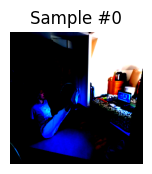

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


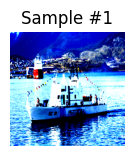

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


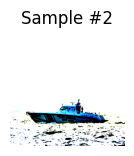

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


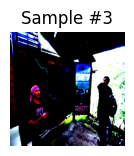

In [19]:
fig = plt.figure()

for i, sample in enumerate(train_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(np.transpose(sample[0], [1,2,0]))
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.show()
    if i == 3:
        break

In [21]:
device = torch.device('cuda')
# device = torch.device('cpu')
# Define your smaller ResNet student model
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=52):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(131072, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=52):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(65536, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    
# Define loss functions
criterion_teacher = nn.CrossEntropyLoss()  # Loss for teacher model
criterion_student = nn.KLDivLoss()  # Knowledge distillation loss

# Instantiate the teacher and student models
teacher_model = DeepNN(num_classes=num_classes).to(device)
student_model = LightNN(num_classes=num_classes).to(device)  # Adjust num_classes as needed


# Define optimizer for the student model
optimizer_student = optim.Adam(student_model.parameters(), lr=learning_rate)
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=learning_rate)


In [ ]:
# Training loop
for epoch in range(num_epochs):
    student_model.train()
    for images, labels, annotations in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_student.zero_grad()
        teacher_optimizer.zero_grad()
        
        # Forward pass
        teacher_outputs = teacher_model(images).to(device)
        student_outputs = student_model(images).to(device)
        
        # Compute loss for knowledge distillation
        kd_loss = criterion_student(
            torch.log_softmax(student_outputs / 5, dim=1),  # Apply temperature scaling
            torch.softmax(teacher_outputs / 5, dim=1)  # Apply temperature scaling
        )
        
        # Compute regular cross-entropy loss
        ce_loss = criterion_teacher(student_outputs, labels)
        
        # Combine the two losses with a weighting factor (alpha)
        alpha = 0.5  # Adjust as needed
        total_loss = alpha * kd_loss + (1 - alpha) * ce_loss
        
        total_loss.backward()
        optimizer_student.step()
        teacher_optimizer.step()

   # Validation
    student_model.eval()
    teacher_model.eval()
    val_loss_student = 0.0
    val_predictions_student = []
    val_targets_student = []
    
    val_loss_teacher = 0.0
    val_predictions_teacher = []
    val_targets_teacher = []
    
    with torch.no_grad():
        for images, labels, annotations in val_loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            student_outputs = student_model(images)
            teacher_outputs = teacher_model(images)
            
            # Compute cross-entropy loss for validation
            student_loss = criterion_teacher(student_outputs, labels)
            teacher_loss = criterion_teacher(teacher_outputs, labels)
            
            val_loss_student += student_loss.item()
            val_loss_teacher += teacher_loss.item()
            
            # Store predictions and ground truth labels for metrics
            val_predictions_student.extend(torch.argmax(student_outputs, dim=1).cpu().numpy())
            val_predictions_teacher.extend(torch.argmax(teacher_outputs, dim=1).cpu().numpy())

            val_targets_student.extend(labels.cpu().numpy())
            val_targets_teacher.extend(labels.cpu().numpy())


    # Calculate validation accuracy
    val_accuracy_student = accuracy_score(val_targets_student, val_predictions_student)
    val_accuracy_teacher = accuracy_score(val_targets_teacher, val_predictions_teacher)
    
    # Print validation results for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}]'
          f' Teacher Loss: {val_loss_teacher / len(val_loader):.4f}'
          f' Teacher Accuracy: {val_accuracy_teacher:.4f}'
          f' Student Loss: {val_loss_student / len(val_loader):.4f}'
          f' Student Accuracy: {val_accuracy_student:.4f}')

# Save the trained student model for future inference
# torch.save(student_model.state_dict(), 'student_model.pth')


In [ ]:
torch.save(student_model.state_dict(), 'student_model.pth')

In [ ]:
torch.save(teacher_model.state_dict(), 'teacher_model.pth')

In [ ]:
accuracy_score(val_targets_student, val_predictions_student)

In [ ]:
accuracy_score(val_targets_teacher, val_predictions_teacher)

In [ ]:
val_loss_student / len(val_loader)

In [ ]:
val_loss_teacher / len(val_loader)